In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats

pd.options.mode.chained_assignment = None

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load data
### Read group data

Depending on the analysis, we require data from all groups, for example to compare psychometrics, or only from the groups where there was no technical error, in order to study trajectories and emergence values as well as psychometrics.

In [3]:
groups_df = pd.read_csv(f"../experiment/groups_data.csv").set_index('Group')
groups_df = groups_df.drop(['Start', 'End', 'Notes'], axis = 1)

In [4]:
groups_df_noerr = groups_df[groups_df.Psi_error == 0 ].drop(['Psi_error', 'Filt_buffer'], axis = 1)

In [5]:
groups_df

,Duration,Manual,Emerged,Filt_buffer,Psi_error
Group,,,,,
A_1,918,0,1,36,1
A_2,2918,1,0,36,0
A_3,575,0,1,36,0
A_4,794,0,1,36,0
A_5,2204,1,0,60,0
A_6,2348,0,1,60,0
A_7,173,1,0,60,1
A_8,3753,0,0,60,0
A_9,4141,0,0,60,0


In [6]:
groups_df_noerr

,Duration,Manual,Emerged
Group,,,
A_2,2918,1,0
A_3,575,0,1
A_4,794,0,1
A_5,2204,1,0
A_6,2348,0,1
A_8,3753,0,0
A_9,4141,0,0
A_10,1140,0,1
B_1,2524,0,1


### Read trajectory emergence
We read the values of emergence $\Psi$ during the gameplay, and add statistics to the group data. We only use data from groups where there was **no error** encountered in the tech, since the emergence values would otherwise not be meaningful.

We need to use the `Filt_buffer` and `Duration`, to find the relevant segment of gameplay. After that is done, we also update the `Duration` to store exactly the number of frames we averaged over.

In [7]:
FRAMERATE = 12
START_THRESHOLD = FRAMERATE * 15

In [8]:
psi, pstats = {}, {}
for g in groups_df_noerr.index:
    start  = int(groups_df.Filt_buffer[g] / 3 * 2 + START_THRESHOLD)
    length =  int(groups_df.Duration[g]) - start + 1

    if os.path.exists(f"psi/{g}-psi.csv"):
        psis = pd.read_csv(f"psi/{g}-psi.csv")
        psis = psis[psis.type == 'Filtered']
        psis = psis[psis.frame >= start]
        psis = psis[psis.frame < start + length]
        psi[g] = np.array(psis.psi)
        pstats[g] = {
            'Psi_max' : psi[g].max(),
            'Psi_min' : psi[g].min(),
            'Psi_avg' : psi[g].mean(),
            'Psi_std' : psi[g].std()
        }

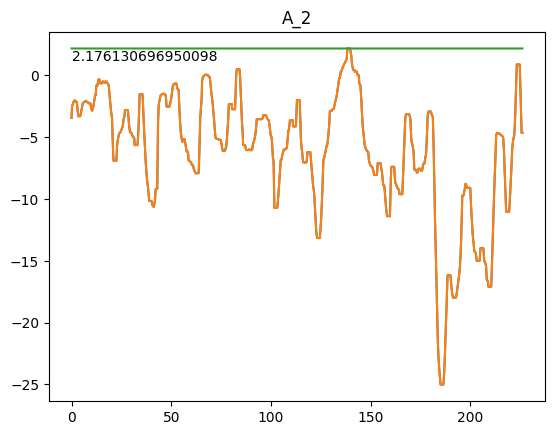

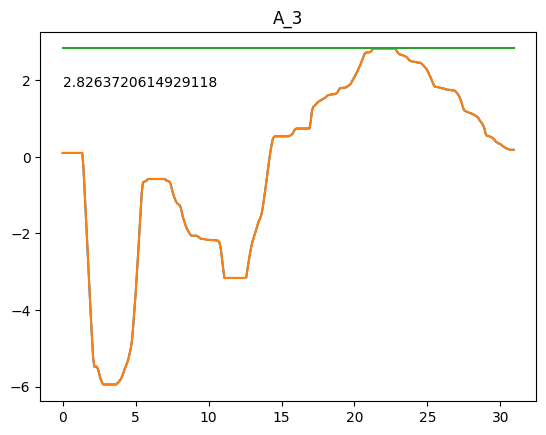

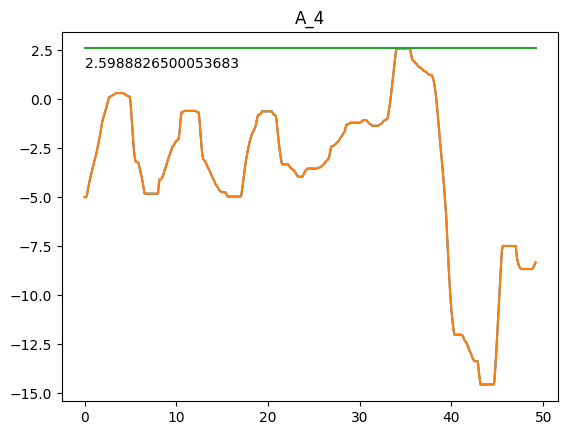

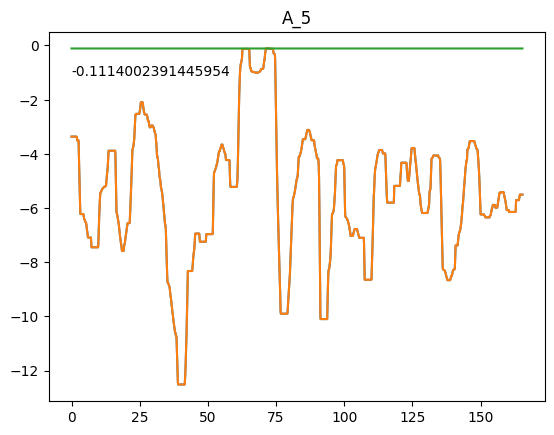

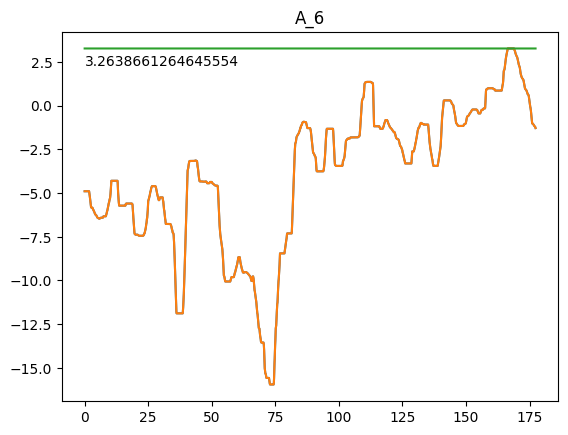

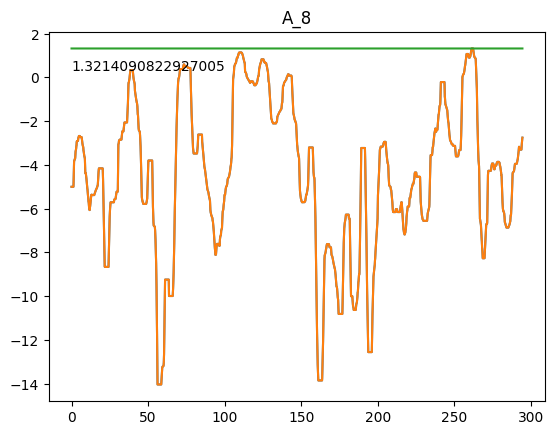

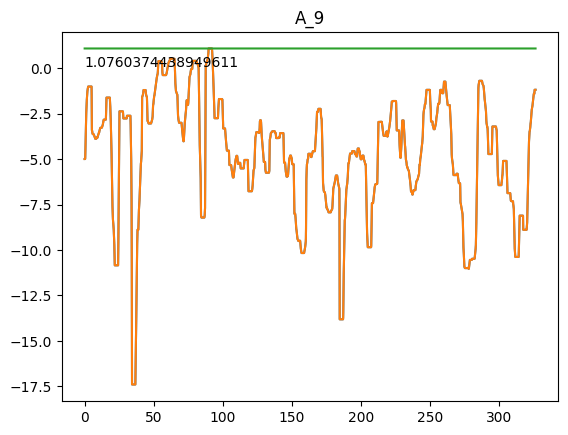

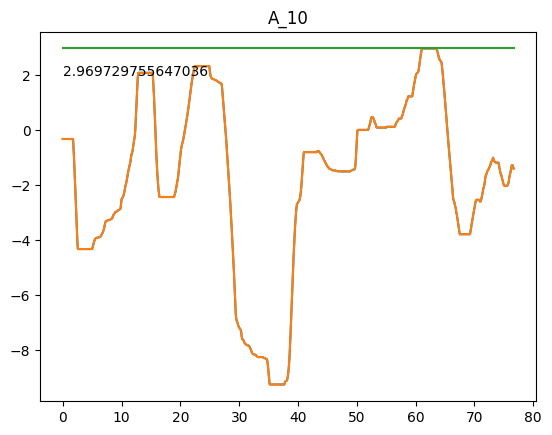

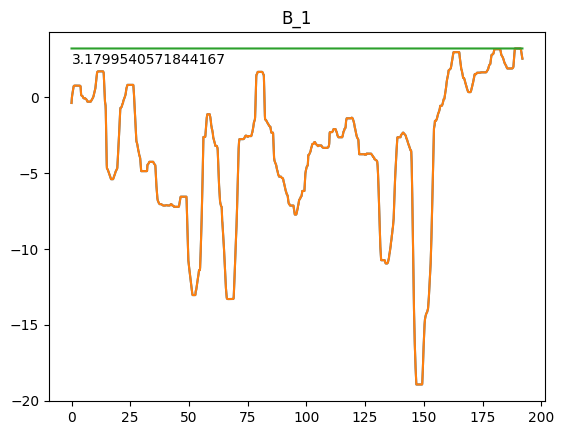

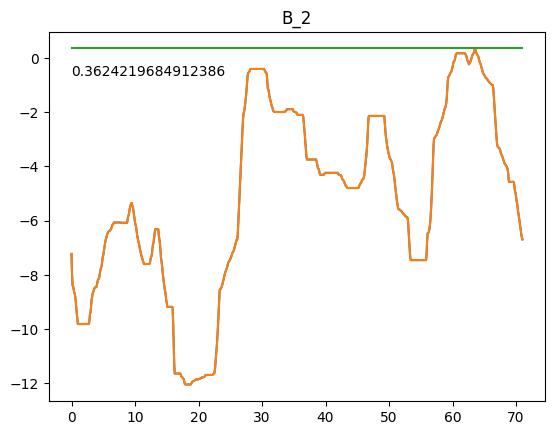

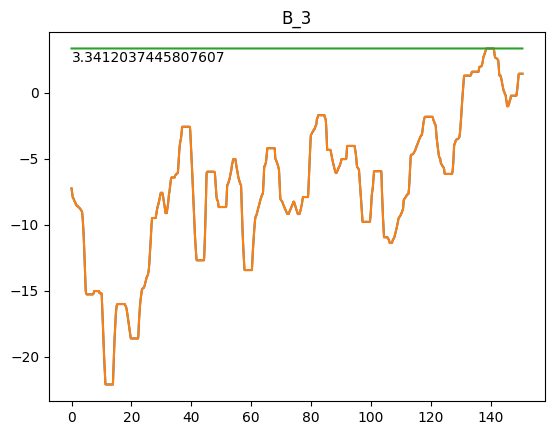

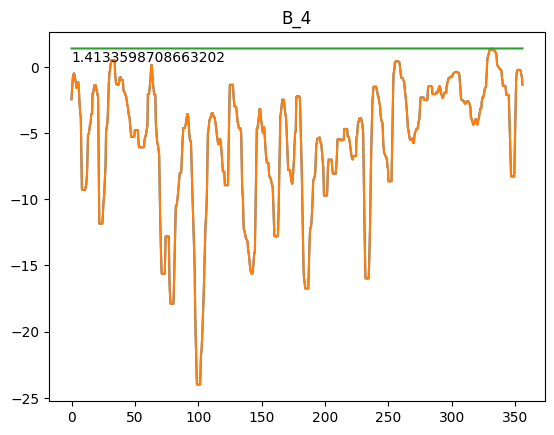

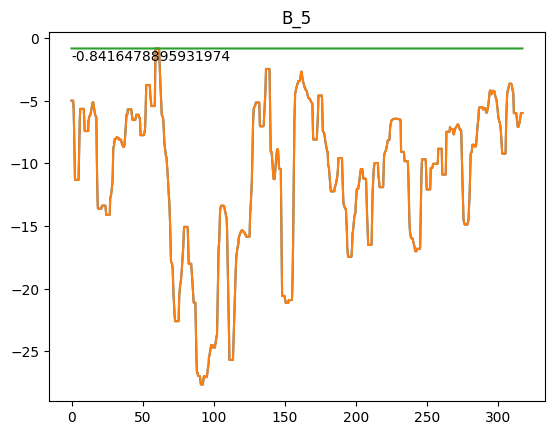

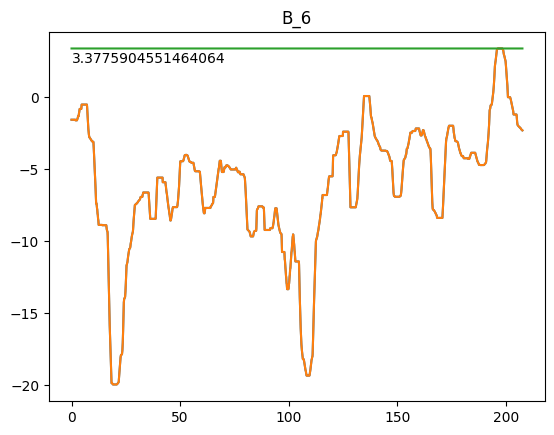

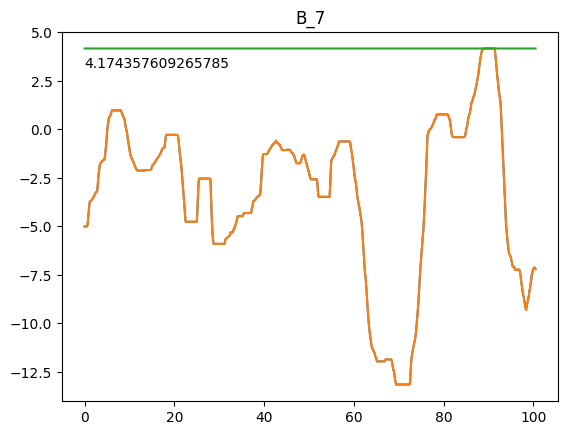

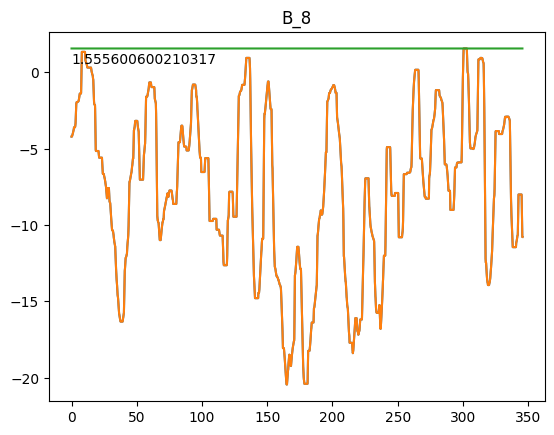

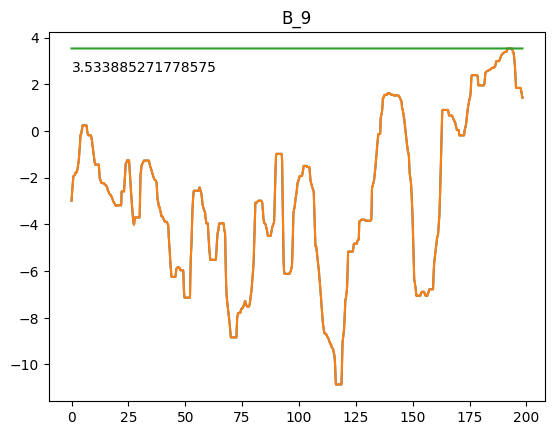

In [9]:
for g in psi.keys():
    plt.plot(np.arange(0, len(psi[g])) / FRAMERATE, psi[g])
    m = max(psi[g])
    l = len(psi[g])
    plt.plot(np.arange(0, l) / FRAMERATE, psi[g])
    plt.plot(np.arange(0, l) / FRAMERATE, [ m ] * l)
    plt.annotate(m, (0, m - 1))
    plt.title(g)
    plt.show()


### Read order parameter data
Instantaneous order parameters have been precomputed for the trajectories in the game play at each individual game state, 12 times per second. We load this data into a dataframe.

Again, we only use data from groups where there was **no error** encountered in the tech, since otherwise the trajectories or their order parameters are either not available or incorrect.

In [10]:
ordp_names = [ 'mean_dist_cmass', 'mean_dist_nearest', 'var_angle', 'vicsek_order' ]

In [11]:
ordp_dfs = {}

for g in groups_df.index:  
    ordp_d = {}
    for p in ordp_names:
        if os.path.exists(f"flocking/{g}/{p}.txt"):
            op = np.loadtxt(f"flocking/{g}/{p}.txt")
            ind = list(range(len(op)))
            ordp_d[p] = op

    if len(ordp_d.keys()):
        ordp_dfs[g] = pd.DataFrame.from_dict(ordp_d, orient = 'index').transpose()

We print mean and std to check integrity, also since we will use mean and std in the future. The constraints are

- `vicsek_order` is always $\le 1$
- since the play area is normalised to $1$, then the mean distance to nearest neighbour, and mean distance to center of mass must be $\le 1$
- since the angle mean and variance are in radians and computed with circular means, means must be $\le 2\pi$ and stds  $\le 4\pi^2$ 

We observe below issues with groups A8 and A9, specifically in `mean_dist_cmass` and `mean_dist_nearest`

In [12]:
for g in groups_df_noerr.index:
    print(g)
    print(f"Mean \n{ordp_dfs[g][ordp_names].mean()}")
    print(f"Std  \n{ordp_dfs[g][ordp_names].std()}")

A_2
Mean 
mean_dist_cmass      0.220832
mean_dist_nearest    0.122658
var_angle            4.515795
vicsek_order         0.435334
dtype: float64
Std  
mean_dist_cmass      0.039971
mean_dist_nearest    0.022746
var_angle            4.118922
vicsek_order         0.242856
dtype: float64
A_3
Mean 
mean_dist_cmass      0.230159
mean_dist_nearest    0.123229
var_angle            6.093858
vicsek_order         0.107965
dtype: float64
Std  
mean_dist_cmass      0.014995
mean_dist_nearest    0.009199
var_angle            3.172720
vicsek_order         0.051746
dtype: float64
A_4
Mean 
mean_dist_cmass      0.288660
mean_dist_nearest    0.169533
var_angle            5.358337
vicsek_order         0.241998
dtype: float64
Std  
mean_dist_cmass      0.026931
mean_dist_nearest    0.021682
var_angle            3.597735
vicsek_order         0.142701
dtype: float64
A_5
Mean 
mean_dist_cmass      0.241589
mean_dist_nearest    0.129874
var_angle            5.571710
vicsek_order         0.473736
dtype: float

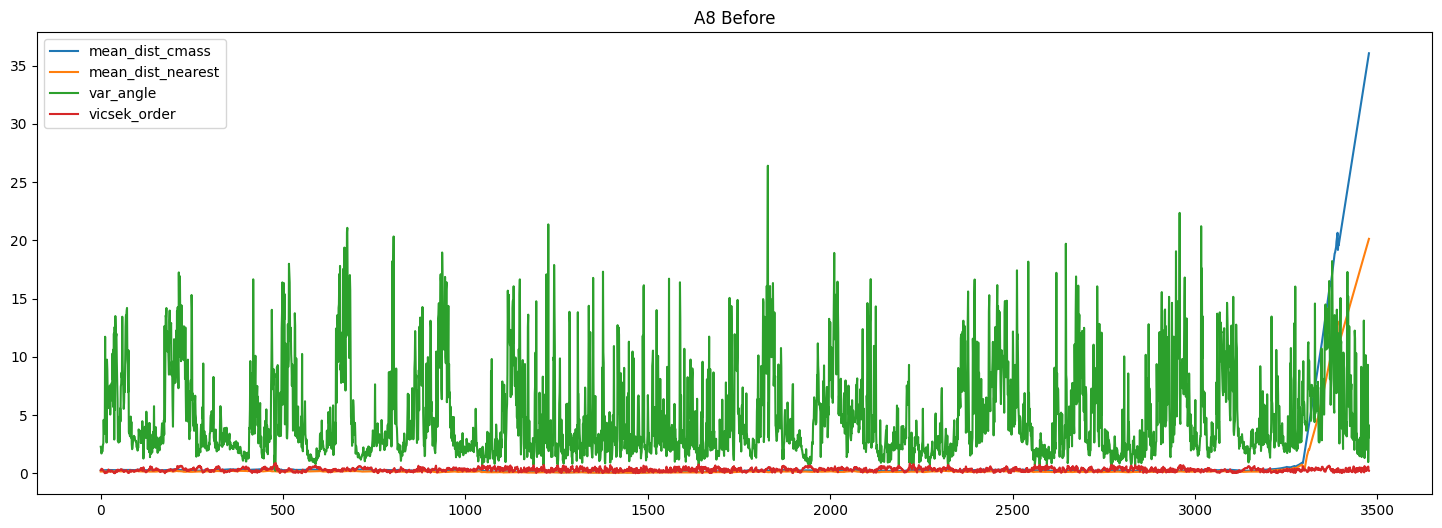

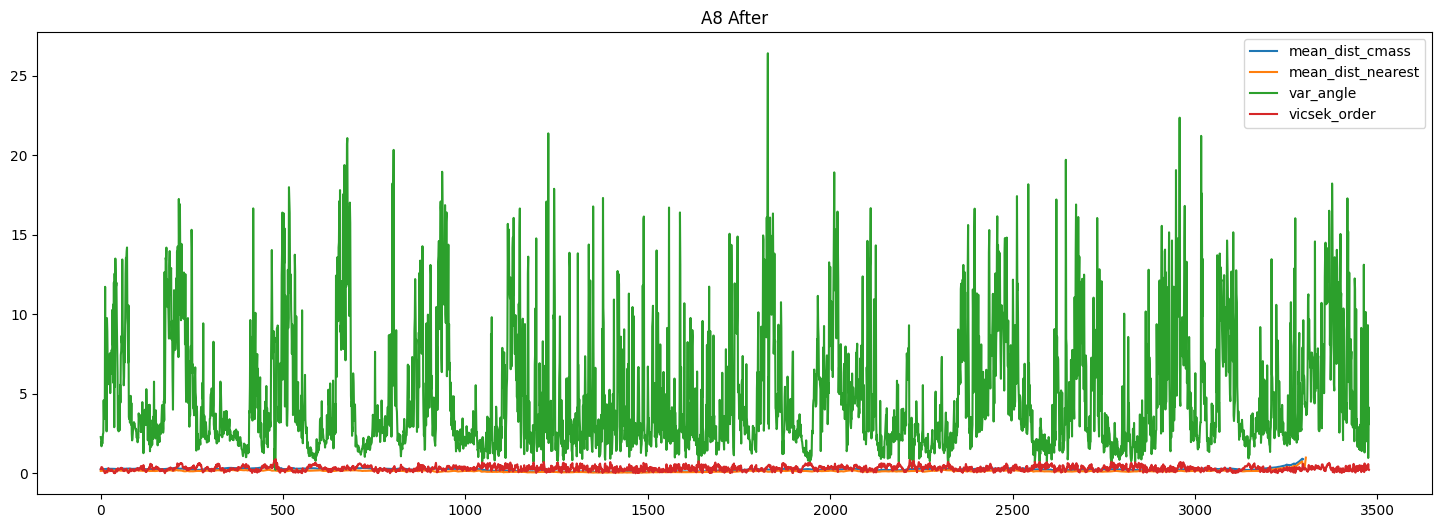

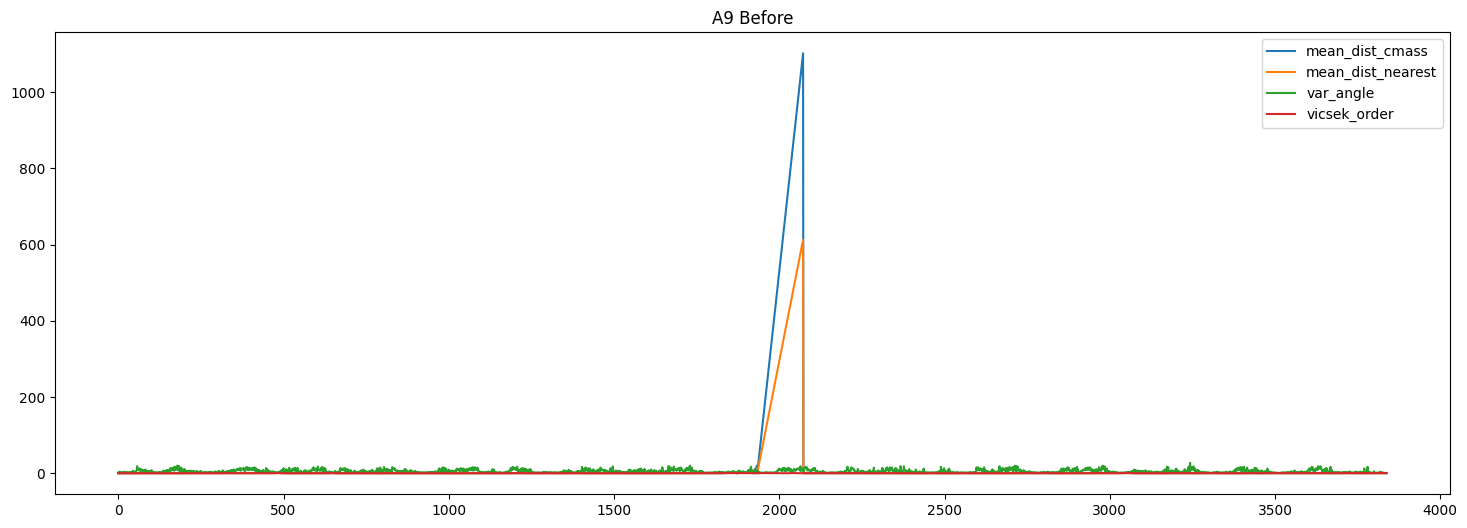

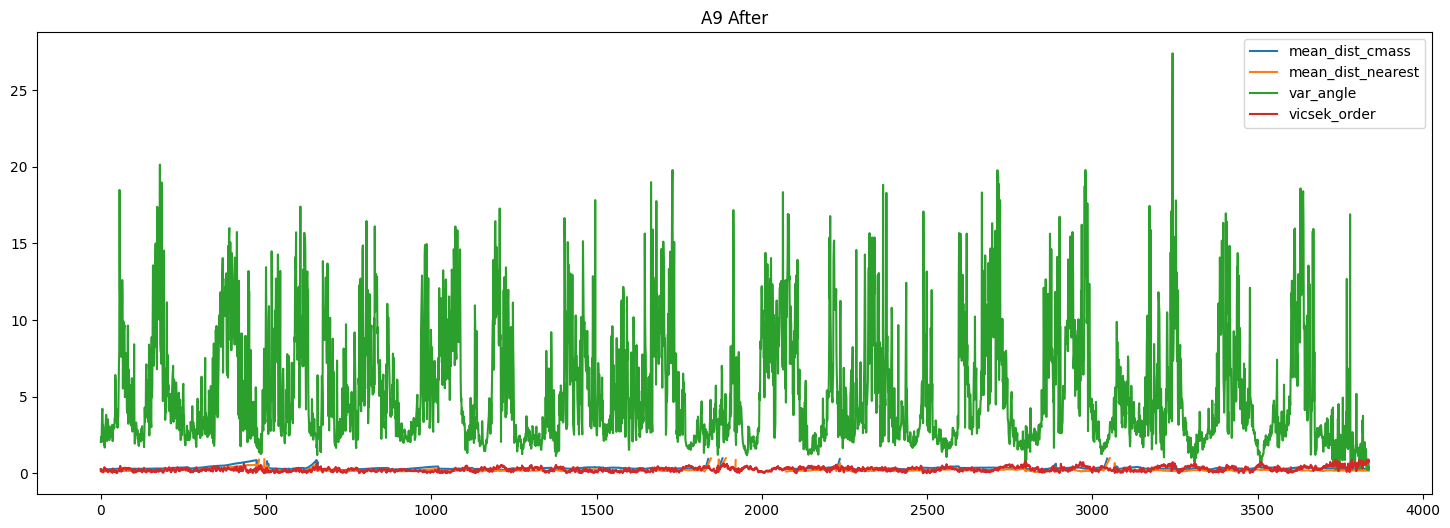

In [13]:
plt.rcParams['figure.figsize'] = 18, 6

temp = ordp_dfs['A_8'].copy()
temp.plot()
plt.title('A8 Before')
temp['mean_dist_cmass']   = temp['mean_dist_cmass'].apply(lambda x: x if x <= 1 else np.nan)
temp['mean_dist_nearest'] = temp['mean_dist_nearest'].apply(lambda x: x if x <= 1 else np.nan)
temp.plot()
plt.title('A8 After')
ordp_dfs['A_8'] = temp

temp = ordp_dfs['A_9'].copy()
temp.plot()
plt.title('A9 Before')
temp['mean_dist_cmass']   = temp['mean_dist_cmass'].apply(lambda x: x if x <= 1 else np.nan)
temp['mean_dist_nearest'] = temp['mean_dist_nearest'].apply(lambda x: x if x <= 1 else np.nan)
temp.plot()
plt.title('A9 After');
ordp_dfs['A_9'] = temp

### Read player questionnaire data
Each player gave questionnaire responses before and after the game. These have been aggregated per-player.

In [14]:
player_df = pd.read_csv('../subj-data/quest/SL_GERF_player_questionnaire.csv')

In [15]:
player_df

,Player,Group,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal
0,A1.1,A_1,3.142857,80.000000,39.166667,63.571429,60.912698
1,A1.2,A_1,3.571429,50.000000,26.500000,48.000000,41.500000
2,A1.4,A_1,3.428571,54.166667,79.166667,50.000000,61.111111
3,A1.5,A_1,4.142857,53.333333,70.000000,82.857143,68.730159
4,A1.6,A_1,3.428571,99.000000,62.500000,0.428571,53.976190
...,...,...,...,...,...,...,...
130,B10.2,B_10,4.428571,51.666667,66.666667,42.857143,53.730159
131,B10.3,B_10,3.571429,45.000000,46.666667,0.000000,30.555556
132,B10.5,B_10,4.428571,83.333333,79.166667,82.857143,81.785714
133,B10.6,B_10,4.142857,0.000000,58.333333,0.000000,19.444444


### Read beauty data
Froma separate study, where 44 subjects rated 10s segments for beauty on a scale from 0 to 10. We average over the subjects to get a mean rating per segment.

In [52]:
beauty_df = pd.read_csv('GERF_beauty_data.csv').set_index(['Group', 'Segment'])
beauty_df

Unnamed: 0     Participant Public ID  Response  \
Group Segment                                                   
A_8   9                 0  5e6627a7ef80c639ac28b01a         4   
B_1   14                1  5e6627a7ef80c639ac28b01a         6   
B_8   27                2  5e6627a7ef80c639ac28b01a         3   
      8                 3  5e6627a7ef80c639ac28b01a         3   
B_1   13                4  5e6627a7ef80c639ac28b01a         4   
...                   ...                       ...       ...   
A_10  7             13896  602a2911a73ba046955f6c58         7   
A_4   1             13897  602a2911a73ba046955f6c58         5   
B_5   16            13898  602a2911a73ba046955f6c58         6   
B_2   5             13899  602a2911a73ba046955f6c58         3   
      6             13900  602a2911a73ba046955f6c58         4   

               Absolute Reaction Time   Emergence  
Group Segment                                      
A_8   9                     21296.589   -3.687048  
B_1   14                    14074.346   -7.927381  
B_8   27                    20737.600   -2.965516  
      8                     25821.069   -8.374948  
B_1   13                    15061.807   -3.506700  
...                               ...         ...  
A_10  7                     11890.280   -0.050254  
A_4   1                     10988.780   -2.435160  
B_5   16                    14748.654  -14.658225  
B_2   5                     14864.703   -3.735530  
      6                     12965.065   -4.846682  

[13901 rows x 5 columns]

In [17]:
beau_means = pd.DataFrame(beauty_df.groupby(
    ['Group', 'Segment'])['Response'].mean())
beau_means['mean_beauty'] = beau_means.Response
beau_means['std_mean_beauty'] = beauty_df.groupby(
    ['Group', 'Segment'])['Response'].std(ddof = 1)
beau_means = beau_means.drop('Response', axis = 1)

beau_means

mean_beauty  std_mean_beauty
Group Segment                              
A_10  1           5.340909         2.123437
      2           5.954545         1.987806
      3           5.727273         2.171310
      4           6.045455         2.352184
      5           5.113636         2.616725
...                    ...              ...
B_9   15          6.818182         1.956180
      16          5.659091         2.391294
      17          6.363636         1.843794
      18          6.840909         1.964134
      19          6.772727         1.815484

[316 rows x 2 columns]

# Create datasets

---------

## Player data

Since we have collected questionnaire data from all groups, regardless of the success or failure of the experimental hardware, we can make use of this data in analysis. The groups experiencing technological issues (e.g. A7) have been given the game reward without winning the game, so they can be included in the category `emerged = 0`, `manual = 1`.

We gather together averages during the gameplay in each group, with questionnaire responses. Each player will have a **single entry** with their questionnaire reponse, joined with their group's performance in the game. 

Note the duration is in frames, so we divide by FPS (in our case 12) to obtain gameplay duration in seconds.


In [18]:
df_player = player_df.join(groups_df, on='Group', how='right')
df_player = df_player.drop([ 'Filt_buffer', 'Psi_error' ], axis = 1).set_index(['Player'])
df_player['Duration'] = df_player['Duration'] / FRAMERATE

In [19]:
pd.set_option('display.max_rows', 140)
df_player

,Group,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal,Duration,Manual,Emerged
Player,,,,,,,,,
A1.1,A_1,3.142857,80.000000,39.166667,63.571429,60.912698,76.500000,0,1
A1.2,A_1,3.571429,50.000000,26.500000,48.000000,41.500000,76.500000,0,1
A1.4,A_1,3.428571,54.166667,79.166667,50.000000,61.111111,76.500000,0,1
A1.5,A_1,4.142857,53.333333,70.000000,82.857143,68.730159,76.500000,0,1
A1.6,A_1,3.428571,99.000000,62.500000,0.428571,53.976190,76.500000,0,1
A1.7,A_1,3.285714,36.666667,83.333333,24.285714,48.095238,76.500000,0,1
A1.8,A_1,2.857143,22.500000,60.833333,16.428571,33.253968,76.500000,0,1
A1.9,A_1,2.785714,45.000000,88.333333,17.142857,50.158730,76.500000,0,1
A1.10,A_1,2.857143,22.833333,80.000000,10.000000,37.611111,76.500000,0,1


In [20]:
df_player.to_csv('GERF_group_player_data.csv')

#### Counting different subgroups


In [21]:
print('\nNumber of subjects and groups in total')
print(len(df_player.index))
print(len(df_player.Group.unique()))

print('\nNumber of subjects and groups in total, without NaNs')
print(len(df_player.dropna().index))
print(len(df_player.dropna().Group.unique()))

print('\nNumber of subjects and groups without manual emergence')
print(len(df_player[df_player.Manual == 0].index))
print(len(df_player[df_player.Manual == 0].Group.unique()))

print('\nNumber of subjects and groups who emerged')
print(len(df_player[df_player.Emerged == 1].index))
print(len(df_player[df_player.Emerged == 1].Group.unique()))

print('\nNumber of subjects and groups who did not emerge (including manual)')
print(len(df_player[df_player.Emerged == 0].index))
print(len(df_player[df_player.Emerged == 0].Group.unique()))

print('\nNumber of subjects and groups who did not emerge (excluding manual)')
print(len(df_player[df_player.Emerged == 0][df_player.Manual == 0].index))
print(len(df_player[df_player.Emerged == 0][df_player.Manual == 0].Group.unique()))


Number of subjects and groups in total
136
20

Number of subjects and groups in total, without NaNs
135
19

Number of subjects and groups without manual emergence
109
17

Number of subjects and groups who emerged
71
11

Number of subjects and groups who did not emerge (including manual)
65
9

Number of subjects and groups who did not emerge (excluding manual)
38
6


/tmp/ipykernel_21827/1315145430.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(df_player[df_player.Emerged == 0][df_player.Manual == 0].index))
/tmp/ipykernel_21827/1315145430.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(df_player[df_player.Emerged == 0][df_player.Manual == 0].Group.unique()))


We also combine the data from the groups which did not error with the average statistics for emergence - we remove groups that errored so we always have a value for $\Psi$.

In [22]:
df_player_noerr = player_df.join(groups_df_noerr, on='Group', how='right')
df_player_noerr = df_player_noerr.set_index(['Player'])
df_player_noerr['Duration'] = df_player_noerr['Duration'] / FRAMERATE
df_player_group_psi = df_player_noerr.join(pd.DataFrame(pstats).T, on='Group', how='outer')

In [23]:
df_player_group_psi

,Group,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal,Duration,Manual,Emerged,Psi_max,Psi_min,Psi_avg,Psi_std
Player,,,,,,,,,,,,,
A2.1,A_2,3.000000,80.000000,83.333333,50.000000,71.111111,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059
A2.2,A_2,3.000000,16.666667,78.333333,51.428571,48.809524,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059
A2.3,A_2,3.000000,3.333333,67.833333,1.857143,24.341270,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059
A2.4,A_2,2.857143,26.666667,82.500000,54.285714,54.484127,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059
A2.5,A_2,2.857143,69.166667,69.166667,66.428571,68.253968,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059
A2.6,A_2,4.000000,26.666667,61.666667,50.000000,46.111111,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059
A2.7,A_2,3.571429,40.000000,65.000000,52.857143,52.619048,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059
A2.8,A_2,3.857143,23.333333,53.333333,22.857143,33.174603,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059
A2.9,A_2,3.285714,78.333333,40.000000,47.142857,55.158730,243.166667,1,0,2.176131,-25.009764,-6.113833,5.061059


In [50]:
df_player_group_psi.to_csv('GERF_group_player_psi_data.csv')

## Group data
To obtain group statistics first, we combine the experimental data for the group, with the `Psi` statistics for that group, and we also take means of the psychometrics reported for that group.

In [25]:
df_group_means = df_player.groupby('Group').mean().join(
    df_player.groupby('Group').std()[
        ['DavisPerspective', 'WattsSelf','WattsOthers','WattsWorld','WattsTotal']],
    rsuffix = '_std')
df_group_means = df_group_means.join(df_player_group_psi.groupby('Group').mean()[
    ['Psi_max', 'Psi_min', 'Psi_avg', 'Psi_std']])

df_group_means

,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal,Duration,Manual,Emerged,DavisPerspective_std,WattsSelf_std,WattsOthers_std,WattsWorld_std,WattsTotal_std,Psi_max,Psi_min,Psi_avg,Psi_std
Group,,,,,,,,,,,,,,,,,
A_1,3.277778,51.500000,65.537037,34.746032,50.594356,76.500000,0.0,1.0,0.432194,25.015690,20.922107,27.610703,11.810011,NaN,NaN,NaN,NaN
A_10,NaN,NaN,NaN,NaN,NaN,95.000000,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2.969730,-9.245994,-1.749647,3.178456
A_2,3.271429,43.000000,62.616667,43.542857,49.719841,243.166667,1.0,0.0,0.412118,27.927928,18.740767,18.483528,14.286027,2.176131,-25.009764,-6.113833,5.061059
A_3,3.085714,47.433333,87.866667,31.228571,55.509524,47.916667,0.0,1.0,0.718559,8.276137,7.775853,7.149711,5.115467,2.826372,-5.946373,-0.268984,2.459303
A_4,3.224490,45.357143,64.666667,35.448980,48.490930,66.166667,0.0,1.0,0.284009,19.859793,13.062882,29.596197,13.172101,2.598883,-14.574288,-3.683445,4.194033
A_5,3.460317,51.944444,68.981481,41.746032,54.223986,183.666667,1.0,0.0,0.467177,16.955825,17.158259,17.670854,11.505612,-0.111400,-12.512813,-5.490027,2.518578
A_6,3.253968,33.814815,70.888889,20.666667,41.790123,195.666667,0.0,1.0,0.629941,19.056831,7.194713,6.166896,8.535183,3.263866,-15.952847,-3.977656,4.138174
A_7,3.321429,35.041667,62.666667,28.357143,42.021825,14.416667,1.0,0.0,0.570152,24.641356,14.677215,19.428121,8.997871,NaN,NaN,NaN,NaN
A_8,3.114286,27.333333,70.666667,23.714286,40.571429,312.750000,0.0,0.0,0.617764,20.159089,8.383184,22.691363,15.965741,1.321409,-14.035158,-4.442354,3.511400


In [26]:
df_group_means.to_csv('GERF_group_means.csv')

## Segmented game data

For a more detailed analysis of the emergent behaviour, we study 10 second segments of the game data. We do so by computing averages and standard deviation of $\Psi$, as well as several instantaneous order parameters used in flocking literature, for each segment. 

In this analysis we will require video recordings for trajectories for all the games, so we must remove all groups that do not have video data, or where there have been any issues, such as a different way of computing emergence, or any errors occurred.

### Segment emergence values
The `psi` dictionary already contains the emergence value for each frame in the game, with the relevant sections of the game already trimmed. We obtain statistics for each 10s segment.

In [27]:
BLOCK_LEN_SEC = 10
BLOCK_LEN_FRAMES = FRAMERATE * BLOCK_LEN_SEC

In [28]:
segment_psi = []

for g in groups_df_noerr.index:    
    length = groups_df_noerr.Duration[g]
    blocks, rem = divmod(length, BLOCK_LEN_FRAMES)  
    if rem <= 20:
        blocks -= 1
        
    for b in range(blocks):
        s = b * BLOCK_LEN_FRAMES
        e = s + BLOCK_LEN_FRAMES
        if e >= length:
            next
        block_psi = psi[g][s: e]
        segment_psi.append({
            'Group':    g,
            'Segment':  b + 1,
            'mean_psi': np.nanmean(block_psi),
            'std_psi':  np.nanstd( block_psi, ddof = 1)
        })

/tmp/ipykernel_21827/2554786866.py:18: RuntimeWarning: Mean of empty slice
  'mean_psi': np.nanmean(block_psi),
/home/m/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [29]:
df_psi = pd.DataFrame(segment_psi).dropna()

In [30]:
df_psi

,Group,Segment,mean_psi,std_psi
0,A_2,1,-2.446542,0.427370
1,A_2,2,-1.158518,0.841010
2,A_2,3,-4.559308,1.360282
3,A_2,4,-5.521123,2.743205
4,A_2,5,-4.628262,3.729847
...,...,...,...,...
343,B_9,16,-6.668520,0.630716
344,B_9,17,-0.547172,2.059900
345,B_9,18,1.175431,1.065776
346,B_9,19,2.681310,0.408756


### Segment order parameter data

Unlike the computation of $\Psi$, the order parameters have only been computed for the relevant segment of gameplay data, and moreover to allow the gameplay data to be split in 10s blocks. Thus there may be less frames with an instantaneous order parameter computed than frames with an instantaneous emergence. Thus we do not remove any states at the beginning or end of the game, but only segment the data in 10s blocks.

Before averaging in blocks we need to make sure that there are no spurious values that would affect the means greatly. Since the gameplay area is normalised to 1x1, then position-based order parameters should be below 1. Vicsek order is always below 1, and the angle variance, being in radians, should be below 10. 

In [31]:
segment_ordp = []

for g in ordp_dfs.keys():
    length = groups_df.Duration[g]
    blocks, rem = divmod(length, BLOCK_LEN_FRAMES)
    if rem <= 20:
        blocks -= 1        

    for b in range(blocks):
        s = b * BLOCK_LEN_FRAMES
        e = s + BLOCK_LEN_FRAMES

        segment = { 'Group': g, 'Segment': b + 1 }    
        for p in ordp_names:
            block_ordp = ordp_dfs[g][p][s: e]
            segment[f"{p}"]      = np.nanmean(block_ordp)
            segment[f"std_{p}"]  = np.nanstd( block_ordp, ddof = 1)
            
        segment_ordp.append(segment)

/tmp/ipykernel_21827/1864207251.py:16: RuntimeWarning: Mean of empty slice
  segment[f"{p}"]      = np.nanmean(block_ordp)
/home/m/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [32]:
df_ordp = pd.DataFrame(segment_ordp).dropna()

In [33]:
df_ordp

,Group,Segment,mean_dist_cmass,std_mean_dist_cmass,mean_dist_nearest,std_mean_dist_nearest,var_angle,std_var_angle,vicsek_order,std_vicsek_order
0,A_2,1,0.221130,0.042343,0.145433,0.021489,6.275370,3.735643,0.270781,0.140430
1,A_2,2,0.186737,0.007012,0.121680,0.009017,3.914421,2.548290,0.217356,0.100903
2,A_2,3,0.182254,0.005901,0.106969,0.007449,4.949723,3.143203,0.185249,0.075569
3,A_2,4,0.163953,0.014682,0.103224,0.012526,5.969588,3.772577,0.241680,0.109943
4,A_2,5,0.205667,0.016449,0.126370,0.011810,5.305103,3.592199,0.203395,0.092963
...,...,...,...,...,...,...,...,...,...,...
342,B_9,15,0.273335,0.068898,0.119038,0.018218,6.132736,4.358454,0.430605,0.150978
343,B_9,16,0.367245,0.007310,0.169526,0.020912,5.261926,4.306272,0.393676,0.113014
344,B_9,17,0.318634,0.018447,0.165304,0.014463,5.800378,3.377374,0.174326,0.043824
345,B_9,18,0.260042,0.014702,0.140029,0.006828,5.669551,3.212880,0.091039,0.042118


### Combine all segment data

We expect to obtain 316 valid segments to have the same data structuring as the Aesthetics data collection, see [experiment data on GitHub](https://github.com/Synch-Live/AestheticsFlask/blob/main/web/static/videos.csv).

In [34]:
df_segment = df_psi.join(df_ordp.set_index(['Group', 'Segment']),
                         on=['Group', 'Segment'], how='right').set_index(['Group', 'Segment'])

In [35]:
df_segment

mean_psi   std_psi  mean_dist_cmass  std_mean_dist_cmass  \
Group Segment                                                             
A_2   1       -2.446542  0.427370         0.221130             0.042343   
      2       -1.158518  0.841010         0.186737             0.007012   
      3       -4.559308  1.360282         0.182254             0.005901   
      4       -5.521123  2.743205         0.163953             0.014682   
      5       -4.628262  3.729847         0.205667             0.016449   
...                 ...       ...              ...                  ...   
B_9   15       0.422074  1.445226         0.273335             0.068898   
      16      -6.668520  0.630716         0.367245             0.007310   
      17      -0.547172  2.059900         0.318634             0.018447   
      18       1.175431  1.065776         0.260042             0.014702   
      19       2.681310  0.408756         0.243723             0.010057   

               mean_dist_nearest  std_mean_dist_nearest  var_angle  \
Group Segment                                                        
A_2   1                 0.145433               0.021489   6.275370   
      2                 0.121680               0.009017   3.914421   
      3                 0.106969               0.007449   4.949723   
      4                 0.103224               0.012526   5.969588   
      5                 0.126370               0.011810   5.305103   
...                          ...                    ...        ...   
B_9   15                0.119038               0.018218   6.132736   
      16                0.169526               0.020912   5.261926   
      17                0.165304               0.014463   5.800378   
      18                0.140029               0.006828   5.669551   
      19                0.129985               0.008803   5.545283   

               std_var_angle  vicsek_order  std_vicsek_order  
Group Segment                                                 
A_2   1             3.735643      0.270781          0.140430  
      2             2.548290      0.217356          0.100903  
      3             3.143203      0.185249          0.075569  
      4             3.772577      0.241680          0.109943  
      5             3.592199      0.203395          0.092963  
...                      ...           ...               ...  
B_9   15            4.358454      0.430605          0.150978  
      16            4.306272      0.393676          0.113014  
      17            3.377374      0.174326          0.043824  
      18            3.212880      0.091039          0.042118  
      19            2.814754      0.079414          0.050706  

[315 rows x 10 columns]

### Combine segment data with group data

In [36]:
df_segment = df_segment.join(groups_df.drop(['Duration', 'Filt_buffer', 'Psi_error'], axis = 1))
df_segment

mean_psi   std_psi  mean_dist_cmass  std_mean_dist_cmass  \
Group Segment                                                             
A_2   1       -2.446542  0.427370         0.221130             0.042343   
      2       -1.158518  0.841010         0.186737             0.007012   
      3       -4.559308  1.360282         0.182254             0.005901   
      4       -5.521123  2.743205         0.163953             0.014682   
      5       -4.628262  3.729847         0.205667             0.016449   
...                 ...       ...              ...                  ...   
B_9   15       0.422074  1.445226         0.273335             0.068898   
      16      -6.668520  0.630716         0.367245             0.007310   
      17      -0.547172  2.059900         0.318634             0.018447   
      18       1.175431  1.065776         0.260042             0.014702   
      19       2.681310  0.408756         0.243723             0.010057   

               mean_dist_nearest  std_mean_dist_nearest  var_angle  \
Group Segment                                                        
A_2   1                 0.145433               0.021489   6.275370   
      2                 0.121680               0.009017   3.914421   
      3                 0.106969               0.007449   4.949723   
      4                 0.103224               0.012526   5.969588   
      5                 0.126370               0.011810   5.305103   
...                          ...                    ...        ...   
B_9   15                0.119038               0.018218   6.132736   
      16                0.169526               0.020912   5.261926   
      17                0.165304               0.014463   5.800378   
      18                0.140029               0.006828   5.669551   
      19                0.129985               0.008803   5.545283   

               std_var_angle  vicsek_order  std_vicsek_order  Manual  Emerged  
Group Segment                                                                  
A_2   1             3.735643      0.270781          0.140430       1        0  
      2             2.548290      0.217356          0.100903       1        0  
      3             3.143203      0.185249          0.075569       1        0  
      4             3.772577      0.241680          0.109943       1        0  
      5             3.592199      0.203395          0.092963       1        0  
...                      ...           ...               ...     ...      ...  
B_9   15            4.358454      0.430605          0.150978       0        1  
      16            4.306272      0.393676          0.113014       0        1  
      17            3.377374      0.174326          0.043824       0        1  
      18            3.212880      0.091039          0.042118       0        1  
      19            2.814754      0.079414          0.050706       0        1  

[315 rows x 12 columns]

### Combine with beauty data

In [37]:
df_segment = df_segment.join(beau_means)

In [53]:
df_segment.to_csv('GERF_beauty_segment_data.csv')

## Metacognition data

We take the answers to 'were you aware your strategies worked' and label them as positive, negative, or neutral.

In [39]:
def label_answer_pos(txt):
    yes = 0
    for w in ['yes', 'yeah', 'seem to work', 'seemed to work', 'was helpful', 'positive', 'somewhat', 'follow']:
        if w in txt.lower():
            yes = 1
            break  
    return yes

def label_answer_neg(txt):
    no = 0
    for i in ['no', 'nope', 'nah', 'not', "don't", "didn't", "wasn't"]:
        if i in txt.lower():
            no = 1
            break
    return no
            
def labels(row):
    if not row['Q2_aware']:
        return 0
    elif row['label_yes'] ^ row['label_no']:
        return 1 if row['label_yes'] else -1
    else:
        return 0
    
def remove_punctuation(text):
    if type(text) is str:
        final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
        return final
    else:
        return ''

In [40]:
df_answers = pd.read_csv('../subj-data/quest/SL_GERF_player_free_questionnaire.csv')

In [41]:
df_metacog = df_answers[['Group','Q2_aware']]
df_metacog.Q2_aware     = df_metacog.Q2_aware.apply(remove_punctuation)
df_metacog['label_yes'] = df_metacog.Q2_aware.apply(label_answer_pos)
df_metacog['label_no']  = df_metacog.Q2_aware.apply(label_answer_neg)
df_metacog['Label']     = df_metacog.apply(labels, axis = 1)
df_metacog['Answer'] = df_metacog['Q2_aware']
df_metacog = df_metacog.drop(['label_yes', 'label_no', 'Q2_aware'], axis = 1)

### Merge metacognition data with the rest of the group information

In [42]:
df_metacog['Emerged'] = df_metacog.Group.apply(lambda g: groups_df.loc[g].Emerged)
df_metacog['Manual'] = df_metacog.Group.apply(lambda g: groups_df.loc[g].Manual)

In [43]:
#pd.options.display.max_colwidth = 150
#pd.options.display.max_rows = 200
df_metacog[df_metacog.Manual == 0]

,Group,Label,Answer,Emerged,Manual
7,A_3,1,Yes as we started moving together in a circula...,1,0
8,A_3,-1,No,1,0
9,A_3,1,Following the person in front and matching the...,1,0
10,A_3,1,Eventually yes,1,0
11,A_3,0,It seemed like the flashing was beginning to s...,1,0
12,A_3,0,The lights seem to be aligning so carried on,1,0
13,A_3,1,I believe that the above strategies worked and...,1,0
14,A_3,1,Yes,1,0
15,A_3,0,,1,0
16,A_3,-1,No,1,0


In [44]:
df_metacog.to_csv('../subj-data/quest/GERF_metacog_autolabel.csv')

### Statistical tests for categorical data

Using Pearsons Chi-squared test. With 2 labels:

In [45]:
dfm = pd.read_csv('GERF_metacog_labelled.csv')

In [46]:
#dfm1 = dfm[dfm.Label != 'Neutral'][dfm.Manual == 0]
dfm1 = dfm[dfm.Manual == 0]
dfm1 = dfm1.dropna()
obs = pd.crosstab(dfm1.Emerged, dfm1.Label)
obs

Label,No,Yes
Emerged,,
0,21,20
1,19,33


In [47]:
exp = stats.chi2_contingency(obs)
exp

(1.461350235849058,
 0.22671540626496173,
 1,
 array([[17.6344086, 23.3655914],
        [22.3655914, 29.6344086]]))

In [48]:
# TODO: what's the relationship to this function?
stats.chisquare(obs, exp[3], axis=None)

Power_divergenceResult(statistic=2.0158052054940017, pvalue=0.5691327642315647)

Note that using the `total` column is mis-interpreted by `chi2_contingency`, which does calculate the total columns and does not need a table with them pre-calculated. One can check by the degree of freedom, which should be `(groups - 1) * (categories - 1)`, i.e. 2, but when adding the extra column it is seen as a category and DOF becomes 6.

```pyhon
obs = pd.crosstab(dfm.Emerged, dfm.Label, margins=True, margins_name='total')
```